In [22]:
%autocall 1

Automatic calling is: Smart


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
import urllib.request
import xgboost as xgb
from IPython.utils import io

In [48]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

In [49]:
try:
    urllib.request.urlretrieve(url, filename="data-week-6.csv")
    print("File downloaded successfully")
except:
    print("Download error")

File downloaded successfully


In [50]:
df = pd.read_csv("data-week-6.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [51]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

# EDA

In [52]:
#categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns

['origin', 'fuel_type', 'drivetrain']

In [53]:
numerical_columns = df.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('fuel_efficiency_mpg')
numerical_columns

['engine_displacement',
 'num_cylinders',
 'horsepower',
 'vehicle_weight',
 'acceleration',
 'model_year',
 'num_doors']

In [54]:
for c in categorical_columns:
    df[c] = df[c].str.lower()
    df[c] = df[c].fillna('NA')

In [55]:
for c in numerical_columns:
    df[c] = df[c].fillna(0)

In [56]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [57]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [58]:
len(df_train), len(df_val), len(df_test)

(5822, 1941, 1941)

In [59]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [60]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [61]:
dv = DictVectorizer(sparse=True)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# Q1 - Decision Tree Regressor

In [67]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

# Q2 - RMSE

In [74]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [75]:
rf = RandomForestRegressor(n_estimators=10,
                          random_state=1,
                          n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [76]:
y_pred = rf.predict(X_val)

In [88]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [89]:
rmse_score = rmse(y_val, y_pred)
print(f"RMSE: {rmse_score:.2f}")

RMSE: 0.46


# Q3 - Changing RF parameters

In [95]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                          random_state=1,
                          n_jobs=-1)

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_score = rmse(y_val, y_pred)

    scores.append((n, rmse_score))
    print(f"n_estimators={n}, RMSE={rmse_score:.3f}")

n_estimators=10, RMSE=0.460
n_estimators=20, RMSE=0.454
n_estimators=30, RMSE=0.452
n_estimators=40, RMSE=0.449
n_estimators=50, RMSE=0.447
n_estimators=60, RMSE=0.445
n_estimators=70, RMSE=0.445
n_estimators=80, RMSE=0.445
n_estimators=90, RMSE=0.445
n_estimators=100, RMSE=0.445
n_estimators=110, RMSE=0.444
n_estimators=120, RMSE=0.444
n_estimators=130, RMSE=0.444
n_estimators=140, RMSE=0.443
n_estimators=150, RMSE=0.443
n_estimators=160, RMSE=0.443
n_estimators=170, RMSE=0.443
n_estimators=180, RMSE=0.442
n_estimators=190, RMSE=0.442
n_estimators=200, RMSE=0.442


In [91]:
columns = ['n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [96]:
print("\nAll Results:")
print(df_scores)


All Results:
    n_estimators      rmse
0             10  0.459578
1             20  0.453591
2             30  0.451687
3             40  0.448721
4             50  0.446657
5             60  0.445460
6             70  0.445126
7             80  0.444984
8             90  0.444861
9            100  0.444652
10           110  0.443579
11           120  0.443912
12           130  0.443703
13           140  0.443355
14           150  0.442898
15           160  0.442761
16           170  0.442801
17           180  0.442362
18           190  0.442494
19           200  0.442479


In [97]:
best_idx = df_scores['rmse'].idxmin()
best_n = df_scores.loc[best_idx, 'n_estimators']
best_rmse = df_scores.loc[best_idx, 'rmse']

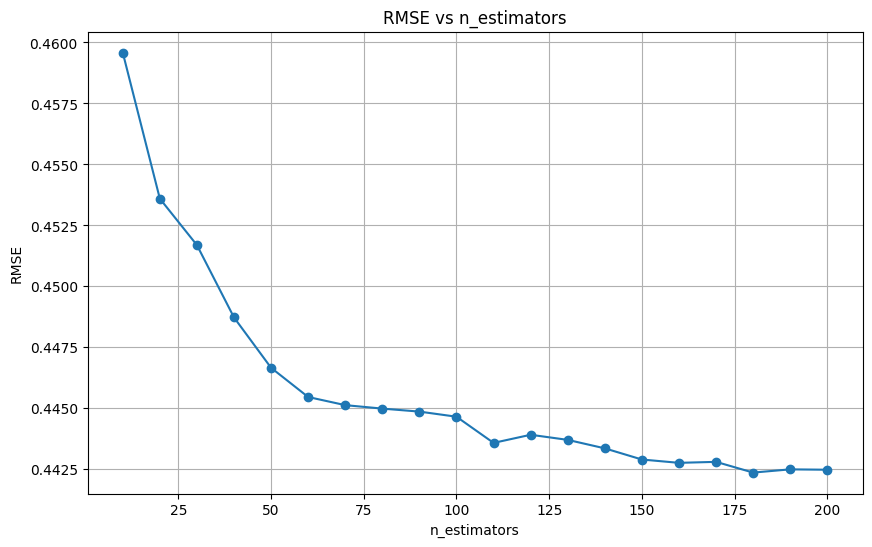

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(df_scores['n_estimators'], df_scores['rmse'], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs n_estimators')
plt.grid(True)
plt.show()

# Q4 - Best max_depth

In [101]:
scores = []

for md in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=md,
                                   random_state=1,
                                   n_jobs=-1)
    
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        rmse_score = rmse(y_val, y_pred)
    
        scores.append((md, n, rmse_score))
        print(f"max_depth={md}, n_estimators={n}, RMSE={rmse_score:.3f}")

max_depth=10, n_estimators=10, RMSE=0.450
max_depth=10, n_estimators=20, RMSE=0.447
max_depth=10, n_estimators=30, RMSE=0.445
max_depth=10, n_estimators=40, RMSE=0.443
max_depth=10, n_estimators=50, RMSE=0.442
max_depth=10, n_estimators=60, RMSE=0.442
max_depth=10, n_estimators=70, RMSE=0.441
max_depth=10, n_estimators=80, RMSE=0.441
max_depth=10, n_estimators=90, RMSE=0.442
max_depth=10, n_estimators=100, RMSE=0.441
max_depth=10, n_estimators=110, RMSE=0.441
max_depth=10, n_estimators=120, RMSE=0.441
max_depth=10, n_estimators=130, RMSE=0.441
max_depth=10, n_estimators=140, RMSE=0.440
max_depth=10, n_estimators=150, RMSE=0.440
max_depth=10, n_estimators=160, RMSE=0.440
max_depth=10, n_estimators=170, RMSE=0.440
max_depth=10, n_estimators=180, RMSE=0.440
max_depth=10, n_estimators=190, RMSE=0.440
max_depth=10, n_estimators=200, RMSE=0.440
max_depth=15, n_estimators=10, RMSE=0.458
max_depth=15, n_estimators=20, RMSE=0.453
max_depth=15, n_estimators=30, RMSE=0.451
max_depth=15, n_estimat

In [102]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [103]:
print("\nAll Results:")
print(df_scores)


All Results:
    max_depth  n_estimators      rmse
0          10            10  0.450249
1          10            20  0.446857
2          10            30  0.445474
3          10            40  0.443067
4          10            50  0.441957
..        ...           ...       ...
75         25           160  0.442800
76         25           170  0.442843
77         25           180  0.442409
78         25           190  0.442534
79         25           200  0.442479

[80 rows x 3 columns]


In [105]:
best_idx = df_scores['rmse'].idxmin()
best_md = df_scores.loc[best_idx, 'max_depth']
best_n = df_scores.loc[best_idx, 'n_estimators']
best_rmse = df_scores.loc[best_idx, 'rmse']

In [107]:
print(f"Best max_depth and RMSE: {best_md} - {best_rmse:.3f}")

Best max_depth and RMSE: 10 - 0.440


# Q5 - Most important feature

In [108]:
model = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [114]:
importances = model.feature_importances_

In [115]:
feature_names = dv.get_feature_names_out()

In [116]:
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [117]:
print(feature_importance_df.head(1))

           feature  importance
13  vehicle_weight     0.95915


# Q6 - XGBoost eta

### ETA 0.3

In [165]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [166]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'validation')]

In [167]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [168]:
s = output.stdout

In [169]:
print(s[:200])

[0]	train-rmse:1.81393	validation-rmse:1.85444
[1]	train-rmse:1.31919	validation-rmse:1.35353
[2]	train-rmse:0.98120	validation-rmse:1.01316
[3]	train-rmse:0.75443	validation-rmse:0.78667
[4]	train-rm


In [180]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [181]:
df_score = parse_xgb_output(output)

In [183]:
best_idx = df_score['val_rmse'].idxmin()
best_rmse = df_score.loc[best_idx, 'val_rmse']

print(f"eta: 0.3, RMSE: {best_rmse:.3f}")

eta: 0.3, RMSE: 0.433


### ETA 0.1

In [185]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [186]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'validation')]

In [187]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [188]:
s = output.stdout

In [189]:
print(s[:200])

[0]	train-rmse:2.28944	validation-rmse:2.34561
[1]	train-rmse:2.07396	validation-rmse:2.12434
[2]	train-rmse:1.88066	validation-rmse:1.92597
[3]	train-rmse:1.70730	validation-rmse:1.74987
[4]	train-rm


In [190]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [191]:
df_score = parse_xgb_output(output)

In [192]:
best_idx = df_score['val_rmse'].idxmin()
best_rmse = df_score.loc[best_idx, 'val_rmse']

print(f"eta: 0.1, RMSE: {best_rmse:.3f}")

eta: 0.1, RMSE: 0.424
